<a href="https://colab.research.google.com/github/chrisouma/chrisouma/blob/main/Reinforcement_Learning_with_TF_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Set up
!sudo apt-get update
!sudo apt-get install-y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,376 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,854 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [110 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [35.0 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,084 kB]
Hit:13 https://ppa.launc

In [3]:
#Importing necessary packages
import os
#using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS']='1'

In [7]:
!pip install future

In [64]:
from __future__ import absolute_import, division, print_function
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import Sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [65]:
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


In [66]:
#setting up a virtual display for rendering OpenAI gym environments
display=pyvirtualdisplay.Display(visible=0,size=(1600,1100)).start()

In [67]:
#to plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

In [68]:
# Setting Hyperparameters
num_iterations = 20000
initial_collect_steps=1000
collect_steps_per_iteration =1
replay_buffer_max_length = 100000
batch_size=64
learning_rate=1e-3
log_interval=100
num_eval_episodes=10
eval_interval=1000

In [69]:
#Setting an environment for the TF-Agents using the tf_agents.environments
#load the CartPole environment from the OpenAI Gym suite
env_name='CartPole-v0'
env=suite_gym.load(env_name)

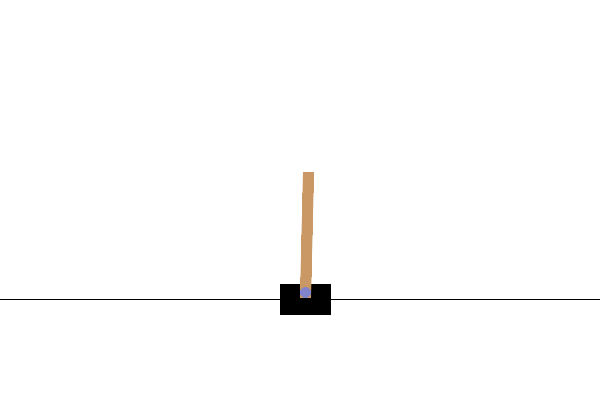

In [70]:
#Rendering the environment to view how it looks
env.reset()
PIL.Image.fromarray(env.render())

In [71]:
#Using the environment.step and time_step_spec() to return specifications
print('observation Spec')
print(env.time_step_spec().observation)
print('reward Spec')
print(env.time_step_spec().reward)

observation Spec
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
reward Spec
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [72]:
#Using the 'action_spec()' which returns the shape, data types and allowed values of valid actions
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [73]:
time_step=env.reset()
print('Timestep:')
print(time_step)
action=np.array(1,dtype=np.int32)
next_time_step=env.step(action)
print('Next Timestep:')
print(next_time_step)

Timestep:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.01067231,  0.01256626,  0.02329803, -0.03446341], dtype=float32)})
Next Timestep:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.01042099,  0.2073465 ,  0.02260876, -0.3197055 ], dtype=float32)})


In [74]:
#Instantiate two environments  for training and model evaluation
train_py_env=suite_gym.load(env_name)
eval_py_env=suite_gym.load(env_name)

In [75]:
#Converting the CartPole environment to tensorflow using the TFPyEnvironment wrapper
train_env=tf_py_environment.TFPyEnvironment(train_py_env)
eval_env=tf_py_environment.TFPyEnvironment(eval_py_env)

In [85]:
#Using the Agent
#using the tf_agents.networks to create a QNetwork which contains of a sequence of tf.keras.layers.Dense layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tf_agents.networks import sequential
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
from tensorflow.keras.layers import Dense
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0,mode='fan_in',distribution='truncated_normal'))
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])


In [86]:
#Using tf_agents.agents.dqn.dqn_agent to instantiate a DQnAgent
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter=tf.Variable(0)
agent=dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)
agent.initialize()

In [87]:
#Defining policies which defines the way an agent beahves in an environment
eval_policy=agent.policy
collect_policy=agent.collect_policy

In [89]:
#Creating policies independent of the agents using the tf_agents.policies.random_tf_policy
random_policy=random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec())

In [91]:
#Calling the 'policy.action(time_step)' inorder to get action from the policy
# action - action to be taken (in this case0 or 1)
#state-used for stateful(ie, RNN-based) policies
#info-auxilliary data,such as log porbabilities of actions
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))
time_step=example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [92]:
#Metrics and Evaluation using the average return
def compute_avg_return(environment,policy,num_episodes=10):
  total_return=0.0
  for _ in range(num_episodes):
    time_step=environment.reset()
    episode_return=0.0
    while not time_step.is_last():
      action_step=policy.action(time_step)
      time_step=environment.step(action_step.action)
      episode_return +=time_step.reward
      total_return+=episode_return
    avg_return=total_return/num_episodes
    return avg_return.numpy()[0]
    #running the computation on the 'random_policy' to show baseline performance in the environmment
    compute_avg_return(eval_env,random_policy,num_eval_episodes)



In [97]:
#Using the 'reverb', an efficient,extensible, and easy-to-use replay system in order to keep track of the data collected from the environment
#the replay buffer is constructed using the specs describing the tensors that are to be stoired which can be obtained from the 'agent.collect_data_spec.'
table_name='uniform_table'
replay_buffer_signature=tensor_spec.from_spec(
    agent.collect_data_spec)
replay_buffer_signature=tensor_spec.add_outer_dim(
    replay_buffer_signature)
table=reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)
reverb_server=reverb.Server([table])
replay_buffer=reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)
rb_observer=reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)
agent.collect_data_spec
agent.collect_data_spec._fields


('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [98]:
#DAta Collection
#Executing the random policy in the environment for steps, recording the data in the replay buffer using the 'PyDriver' to run the experience collecting loop
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.01325836,  0.7713843 , -0.03638182, -1.2010822 ], dtype=float32)}),
 ())

In [99]:
#Enabling the agent access the replay buffer which will be provided by creating an iterable 'tf.data.Dataset' to feed the agent
#Dataset generates trajectories with shape[Bx2x...]
dataset=replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [100]:
iterator=iter(dataset)
print(iterator)

In [101]:
#Training the agent
try:
  %%time
except:
  pass
#Optimize by wrapping some of the code in a graph using TF function
agent.train=common.function(agent.train)
#Reset the train step
agent.train_step_counter.assign(0)
#Evaluate agent's policy before training
avg_return=compute_avg_return(eval_env,agent.policy,num_eval_episodes)
returns=[avg_return]
#Reset the environment
time_step=train_py_env.reset()
#Create a driver to collect the experience
collect_driver=py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)
for _ in range(num_iterations):
  #Collect few steps and save to the replay buffer
  time_step,_=collect_driver.run(time_step)
  #Sample a batch of the data from buffer and update the agent's network
  experience, unused_info=next(iterator)
  train_loss=agent.train(experience).loss
  step=agent.train_step_counter.numpy()
  if step% log_interval==0:
    print('step={0}:loss={1}'.format(step,train_loss))
  if step% eval_interval==0:
    avg_return=compute_avg_return(eval_env,agent.policy,num_eval_episodes)
    print('step={0}:Average Return={1}'.format(step,avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step=100:loss=49.087982177734375
step=200:loss=56.024898529052734
step=300:loss=42.737030029296875
step=400:loss=33.219825744628906
step=500:loss=10.28372573852539
step=600:loss=38.52490234375
step=700:loss=36.00163650512695
step=800:loss=36.970542907714844
step=900:loss=99.053466796875
step=1000:loss=92.7410888671875
step=1000:Average Return=556.5
step=1100:loss=329.28009033203125
step=1200:loss=330.28045654296875
step=1300:loss=156.83935546875
step=1400:loss=270.86395263671875
step=1500:loss=1553.5098876953125
step=1600:loss=513.1344604492188
step=1700:loss=615.3523559570312
step=1800:loss=538.640869140625
step=1900:loss=915.9217529296875
step=2000:loss=189.30657958984375
step=2000:Average Return=891.0999755859375
step=2100:loss=164.49334716796875
step=2200:loss=1268.6756591796875
step=2300:loss=238.39736938476562
step=2400:loss=949.366943359375
step=2500:loss=906.7010498046875
step=2600:loss=1939.8099365234375
step=2700:loss=1586.6396484375
step=2800:loss=435.82415771484375
step=290

(-50.0, 550.0)

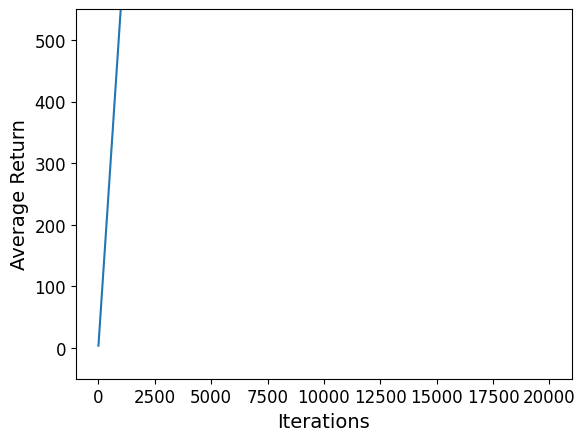

In [103]:
#Visualizations
iterations=range(0,num_iterations+1,eval_interval)
plt.plot(iterations,returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=550,bottom=-50)

In [104]:
#Videos, creating a function to embed videos in the notebook
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [110]:
#iterating through a few episodes of the Cartpole game with the agent
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [111]:
create_policy_eval_video(random_policy, "random-agent")